In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random

In [2]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['persuasion'] = random.gauss(0.5, 0.1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        # Select a random edge and update node opinions and edge weight
        edge = random.choice(list(self.graph.edges))
        weight = self.graph.edges[edge]['weight']
        opinions = [self.graph.nodes[n]['opinion'] for n in edge]
        
        nodes = list(self.graph.nodes)
        # while we haven't found a new edge to create
        while True:
            # get the path length value to represent degree of connection
            try:
                path_length = -1
                new_node = random.choice(nodes)
                new_edge = (edge[0], new_node)
                path_exists = nx.bidirectional_dijkstra(self.graph, new_node, edge[1])
                # if the edge doesnt already exist and there is a path
                if new_edge not in self.graph.edges and path_exists:
                    path_length = nx.shortest_path_length(self.graph, source=new_node, target=edge[1])
                    break
            except:
                # if there isnt a path between the new node and the selected edge node, continue
                continue
    
        # add edge to graph based on preexisting weight and length of path to neighbor
        p_add = path_length*weight/20
        if random.random() < p_add:
            self.graph.add_edge(new_edge[0], new_edge[1], weight=weight*.7)
        
        for i in [0, 1]:
            # multiply persuasion by the opinion delta to weaken or (rarely) amplify the opinion delta
            persuasion = self.graph.nodes[edge[1-i]]['persuasion']
            self.graph.nodes[edge[i]]['opinion'] = (
                opinions[i] + self.alpha * weight * persuasion * (opinions[1-i] - opinions[i]))
        self.graph.edges[edge]['weight'] = (
            weight +
            self.beta * weight * (1-weight) *
            (1 - self.gamma * abs(opinions[0] - opinions[1])))
        
        # Remove very weak connections
        if self.graph.edges[edge]['weight'] < 0.05:
            self.graph.remove_edge(*edge)
        self.step += 1

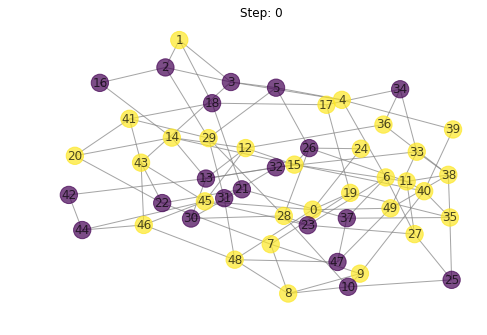

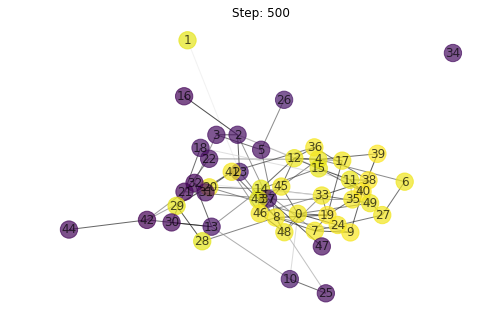

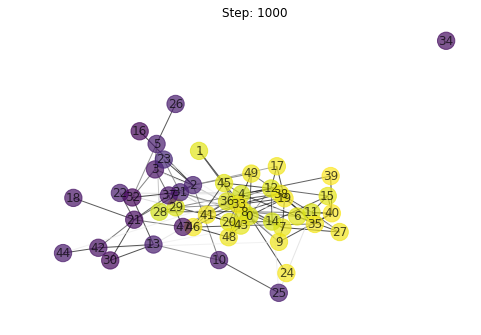

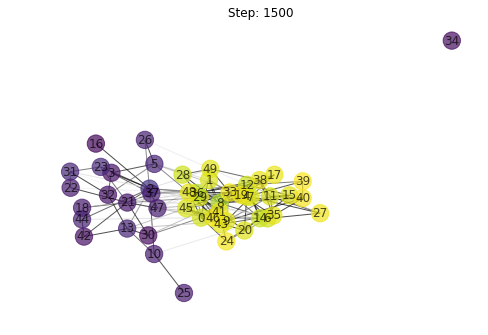

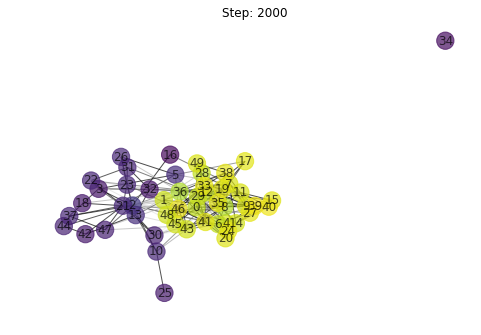

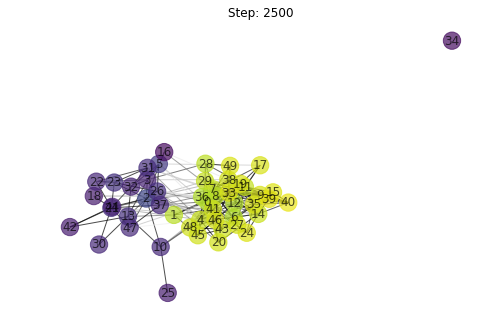

In [3]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(5):
    for i in range(500):
        sim.update()
    plt.figure()
    sim.observe()
plt.show()
plt.close()